# Myocardium Thickness Caliper (Local Image Only)

This notebook enables interactive measurement of **myocardial wall thickness** on a local CMR image.  
It uses the known field-of-view to convert pixel distances to **millimeters**.

**Default scale:** a **128 × 128 px** image covering **160 × 160 mm** ⇒ **1.25 mm/pixel**.

**Workflow**
1. Run the **Interactive backend** cell (enables clicking).
2. Run the **Scale** cell (confirm/change the pixel spacing).
3. Run the **Caliper** cell and left‑click two points across the myocardial wall.
   - Press **c** to clear all measurements.
   - Press **s** to save a CSV and annotated PNG into `/mnt/data/`.

> If clicks don't register, ensure the interactive backend says 'widget' or 'notebook'; otherwise restart the kernel and run the backend cell again.


In [20]:
# --- Interactive backend for Matplotlib ---
# Try 'widget' (needs ipympl) then fall back to 'notebook' (nbagg).
try:
    get_ipython().run_line_magic('matplotlib', 'widget')
    print("Using interactive backend: widget (ipympl)")
except Exception as e_widget:
    try:
        get_ipython().run_line_magic('matplotlib', 'notebook')
        print("Using interactive backend: notebook (nbagg)")
    except Exception as e_nb:
        import matplotlib
        print("WARNING: Interactive backend could not be set. Current backend:", matplotlib.get_backend())
        print("Clicks may not work with 'inline'. Restart the kernel, then run this cell first.")

Using interactive backend: widget (ipympl)


In [22]:
# --- Scale (pixels → millimeters) ---
# Confirm or change these values as needed for your image/FOV.
img_width_px = 128
img_height_px = 128
fov_width_mm = 160.0
fov_height_mm = 160.0

mm_per_px_x = fov_width_mm / img_width_px
mm_per_px_y = fov_height_mm / img_height_px
MM_PER_PIXEL = (mm_per_px_x + mm_per_px_y) / 2.0

print(f"Pixel spacing set to: {MM_PER_PIXEL:.4f} mm/pixel "
      f"(from {img_width_px}x{img_height_px} px → {fov_width_mm}x{fov_height_mm} mm)")

Pixel spacing set to: 1.2500 mm/pixel (from 128x128 px → 160.0x160.0 mm)


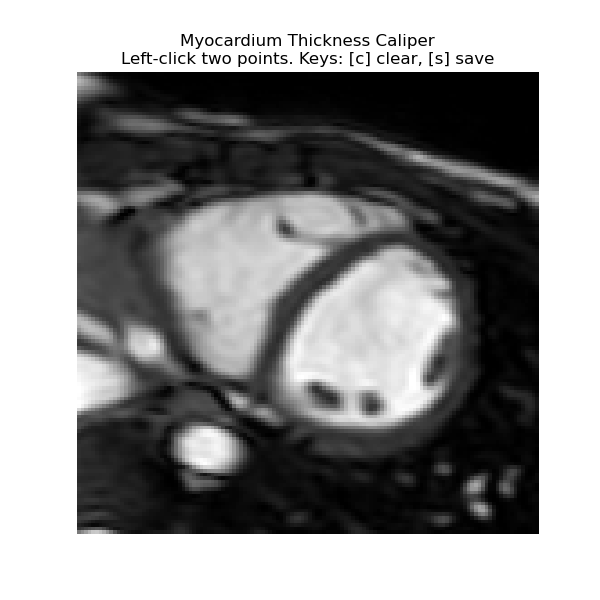

Instructions: click two points to measure; 'c' to clear; 's' to save CSV+PNG to .
Current pixel spacing: 1.2500 mm/pixel


In [24]:
# --- Thickness caliper (LOCAL image only) ---
# Loads only the local image and lets you click two points to measure distance in px and mm.
# If you ran this cell first, it will default the scale to 1.25 mm/pixel (128→160 mm).

IMG_PATH = "C01.png"   # local image only

import os, csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image

# Ensure a default if MM_PER_PIXEL wasn't set yet
if 'MM_PER_PIXEL' not in globals():
    MM_PER_PIXEL = 160.0 / 128.0
    print(f"[Note] MM_PER_PIXEL was not set. Using default {MM_PER_PIXEL:.4f} mm/pixel (128→160 mm).")

assert os.path.exists(IMG_PATH), f"Image not found at {IMG_PATH}"
img = Image.open(IMG_PATH).convert("L")
img_np = np.array(img)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_np, cmap="gray")
ax.set_title("Myocardium Thickness Caliper\nLeft-click two points. Keys: [c] clear, [s] save")
ax.axis("off")

measurements = []
clicks = []
graphics = []

def _distance_pixels(p1, p2):
    return float(np.hypot(p2[0] - p1[0], p2[1] - p1[1]))

def _draw_line_and_label(x1, y1, x2, y2, dpx, dmm):
    line = Line2D([x1, x2], [y1, y2], linewidth=2)
    ax.add_line(line)
    midx, midy = (x1 + x2) / 2, (y1 + y2) / 2
    label = f"{dpx:.2f} px  |  {dmm:.2f} mm"
    txt = ax.text(midx, midy, label, fontsize=10, bbox=dict(facecolor="white", alpha=0.6))
    fig.canvas.draw_idle()
    return [line, txt]

def on_click(event):
    if event.inaxes != ax or event.button != 1:
        return
    clicks.append((event.xdata, event.ydata))
    if len(clicks) == 2:
        p1, p2 = clicks
        dpx = _distance_pixels(p1, p2)
        dmm = dpx * MM_PER_PIXEL
        arts = _draw_line_and_label(p1[0], p1[1], p2[0], p2[1], dpx, dmm)
        graphics.extend(arts)
        measurements.append({
            "x1": p1[0], "y1": p1[1],
            "x2": p2[0], "y2": p2[1],
            "distance_px": dpx,
            "distance_mm": dmm,
        })
        clicks.clear()

def on_key(event):
    if event.key == 'c':
        for art in graphics:
            try:
                art.remove()
            except Exception:
                pass
        graphics.clear()
        measurements.clear()
        clicks.clear()
        fig.canvas.draw_idle()
    elif event.key == 's':
        ts = datetime.now().strftime("%Y%m%d-%H%M%S")
        csv_path = f"myocardium_measurements_{ts}.csv"
        png_path = f"myocardium_annotated_{ts}.png"
        with open(csv_path, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=["x1","y1","x2","y2","distance_px","distance_mm"])
            writer.writeheader()
            for row in measurements:
                writer.writerow(row)
        fig.savefig(png_path, dpi=200, bbox_inches="tight")
        print(f"Saved: {csv_path}")
        print(f"Saved: {png_path}")

cid_click = fig.canvas.mpl_connect('button_press_event', on_click)
cid_key = fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()

print("Instructions: click two points to measure; 'c' to clear; 's' to save CSV+PNG to .")
print(f"Current pixel spacing: {MM_PER_PIXEL:.4f} mm/pixel")